# Empirical Evaluation of Deep Q-Learning against Double Q-Learning

### Empirical Evaluation: DQN vs Double DQN on Taxi-v3

This file performs an empirical evaluation of **DQN** and **Double DQN** on the **Taxi-v3** environment using a consistent architecture and training setup.

#### Environment

**Taxi-v3** from `gym` is a discrete gridworld where a taxi must pick up and drop off passengers at designated locations. It serves as a standard benchmark for evaluating discrete action-value methods like Q-learning.

#### Experimental Setup

- **Frameworks**: `tensorflow==2.12`, `keras-rl2`, `gym==0.23.1`

#### Agent Architecture

- **Input**: One-hot encoded state (500-dimensional)
- **Hidden layers**: 2 × `Dense(64)` with ReLU activations
- **Output**: Q-values for each action

#### Training Configuration

- **Total steps**: 50,000  
- **Exploration strategy**: ε-greedy with ε = 0.1  
- **Warm-up period**: 1,000 steps  
- **Target model update frequency**: every 10,000 steps  



## Install Dependencies

In [1]:
!pip install tensorflow==2.12
!pip install gym==0.23.1
!pip install keras-rl2

## Imports and environment setup

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Flatten
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.optimizers.legacy import Adam

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.core import Processor



/usr/local/lib/python3.11/dist-packages/tensorflow/python/debug/cli/debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/util.py:52: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs.
  from jax import xla_computation as _xla_computation


## Initialize Environment

In [3]:
env = gym.make('Taxi-v3')
print("No of state = ", env.observation_space.n)
print("No of actions =", env.action_space.n)


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

No of state =  500
No of actions = 6


## Custom Processor for One-Hot Encoding


In [4]:
class TaxiProcessor(Processor):
    def process_observation(self, observation):
        one_hot = np.zeros(500)
        one_hot[observation] = 1.0
        return one_hot

    def process_reward(self, reward):
        return reward

## DQN Model Definition

In [5]:
# Cell A1: Setup basic model architecture (shallow network)
def build_basic_model():
    model = Sequential()
    model.add(Flatten(input_shape=(1, 500)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(env.action_space.n, activation='linear'))
    return model

model_basic_dqn = build_basic_model()
model_basic_ddqn = build_basic_model()


## Shared processor and memory


In [6]:
# Shared processor and memory
memory_basic = SequentialMemory(limit=50000, window_length=1)
processor_basic = TaxiProcessor()

policy_basic = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr='eps',
    value_max=1.0,
    value_min=0.1,
    value_test=0.05,
    nb_steps=20000
)


## Setup basic DQN agent

In [7]:
# Setup basic DQN agent
dqn_basic = DQNAgent(
    model=model_basic_dqn,
    nb_actions=env.action_space.n,
    memory=memory_basic,
    processor=processor_basic,
    nb_steps_warmup=500,
    gamma=0.99,
    policy=policy_basic,
    enable_double_dqn=False,
    target_model_update=500
)

dqn_basic.compile(Adam(learning_rate=1e-3), metrics=['mae'])
history_dqn_basic = dqn_basic.fit(env, nb_steps=50000, visualize=False, verbose=1)


Training for 50000 steps ...
Interval 1 (0 steps performed)
   91/10000 [..............................] - ETA: 11s - reward: -3.7692

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 100s 10ms/step - reward: -3.1738
51 episodes - episode_reward: -620.941 [-830.000, -53.000] - loss: 0.415 - mae: 8.678 - mean_q: -7.159 - mean_eps: 0.764 - prob: 1.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: -1.9444
54 episodes - episode_reward: -357.537 [-578.000, -17.000] - loss: 0.597 - mae: 15.351 - mean_q: -14.837 - mean_eps: 0.325 - prob: 1.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 101s 10ms/step - reward: -1.2214
78 episodes - episode_reward: -156.718 [-308.000, 13.000] - loss: 1.061 - mae: 17.952 - mean_q: -17.055 - mean_eps: 0.100 - prob: 1.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 105s 10ms/step - reward: -1.2109
82 episodes - episode_reward: -149.915 [-299.000, 13.000] - loss: 1.230 - mae: 16.236 - mean_q: -11.334 - mean_eps: 0.100 - prob: 1.000

Interval 5 (40000 steps per

## Evaluate basic DQN agent

In [8]:
# Evaluate basic DQN agent
results_dqn_basic = dqn_basic.test(env, nb_episodes=50, visualize=False)
print("DQN Basic - Test Rewards:", results_dqn_basic.history['episode_reward'])
print("DQN Basic - Avg Test Reward:", np.mean(results_dqn_basic.history['episode_reward']))


Testing for 50 episodes ...
Episode 1: reward: -200.000, steps: 200
Episode 2: reward: -200.000, steps: 200
Episode 3: reward: 6.000, steps: 15
Episode 4: reward: 3.000, steps: 18
Episode 5: reward: -200.000, steps: 200
Episode 6: reward: 3.000, steps: 18
Episode 7: reward: -200.000, steps: 200
Episode 8: reward: 6.000, steps: 15
Episode 9: reward: 4.000, steps: 17
Episode 10: reward: -200.000, steps: 200
Episode 11: reward: 8.000, steps: 13
Episode 12: reward: -200.000, steps: 200
Episode 13: reward: 6.000, steps: 15
Episode 14: reward: -200.000, steps: 200
Episode 15: reward: -200.000, steps: 200
Episode 16: reward: -200.000, steps: 200
Episode 17: reward: 4.000, steps: 17
Episode 18: reward: 10.000, steps: 11
Episode 19: reward: 11.000, steps: 10
Episode 20: reward: -200.000, steps: 200
Episode 21: reward: 4.000, steps: 17
Episode 22: reward: 7.000, steps: 14
Episode 23: reward: -200.000, steps: 200
Episode 24: reward: -200.000, steps: 200
Episode 25: reward: -200.000, steps: 200
Ep

## Setup and train basic Double DQN agent

In [9]:
# Setup and train basic Double DQN agent
ddqn_basic = DQNAgent(
    model=model_basic_ddqn,
    nb_actions=env.action_space.n,
    memory=memory_basic,
    processor=processor_basic,
    nb_steps_warmup=500,
    gamma=0.99,
    policy=policy_basic,
    enable_double_dqn=True,
    target_model_update=500
)

ddqn_basic.compile(Adam(learning_rate=1e-3), metrics=['mae'])
history_ddqn_basic = ddqn_basic.fit(env, nb_steps=50000, visualize=False, verbose=1)


Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 121s 12ms/step - reward: -3.1621
59 episodes - episode_reward: -527.390 [-902.000, -7.000] - loss: 0.777 - mae: 8.700 - mean_q: -6.398 - mean_eps: 0.764 - prob: 1.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 125s 13ms/step - reward: -1.8136
80 episodes - episode_reward: -231.250 [-569.000, 4.000] - loss: 0.698 - mae: 11.210 - mean_q: -2.330 - mean_eps: 0.325 - prob: 1.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 128s 13ms/step - reward: -1.1782
101 episodes - episode_reward: -117.782 [-299.000, 11.000] - loss: 0.559 - mae: 10.391 - mean_q: -1.617 - mean_eps: 0.100 - prob: 1.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 129s 13ms/step - reward: -1.0153
163 episodes - episode_reward: -62.123 [-299.000, 14.000] - loss: 0.619 - mae: 12.261 - mean_q: -4.726 - mea

## Evaluate basic DDQN agent

In [10]:
# Evaluate basic DDQN agent
results_ddqn_basic = ddqn_basic.test(env, nb_episodes=50, visualize=False)
print("Double DQN Basic - Test Rewards:", results_ddqn_basic.history['episode_reward'])
print("Double DQN Basic - Avg Test Reward:", np.mean(results_ddqn_basic.history['episode_reward']))


Testing for 50 episodes ...
Episode 1: reward: 3.000, steps: 18
Episode 2: reward: 4.000, steps: 17
Episode 3: reward: -200.000, steps: 200
Episode 4: reward: 11.000, steps: 10
Episode 5: reward: 11.000, steps: 10
Episode 6: reward: 10.000, steps: 11
Episode 7: reward: 6.000, steps: 15
Episode 8: reward: -200.000, steps: 200
Episode 9: reward: 11.000, steps: 10
Episode 10: reward: -200.000, steps: 200
Episode 11: reward: 8.000, steps: 13
Episode 12: reward: 12.000, steps: 9
Episode 13: reward: 9.000, steps: 12
Episode 14: reward: -200.000, steps: 200
Episode 15: reward: -200.000, steps: 200
Episode 16: reward: 8.000, steps: 13
Episode 17: reward: 9.000, steps: 12
Episode 18: reward: -200.000, steps: 200
Episode 19: reward: 6.000, steps: 15
Episode 20: reward: -200.000, steps: 200
Episode 21: reward: 7.000, steps: 14
Episode 22: reward: 11.000, steps: 10
Episode 23: reward: -200.000, steps: 200
Episode 24: reward: 9.000, steps: 12
Episode 25: reward: 4.000, steps: 17
Episode 26: reward:


## Model Definition Update

In [11]:
'''
# old model
model = Sequential()
model.add(Flatten(input_shape=(1, 500)))
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(env.action_space.n, activation='linear'))
'''


def build_improved_model():
    model = Sequential()
    model.add(Flatten(input_shape=(1, 500)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(env.action_space.n, activation='linear'))
    return model

model = build_improved_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32064     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 6)                 198       
                                                                 
Total params: 38,502
Trainable params: 38,502
Non-trainable params: 0
_________________________________________________________________
None


## Setup memory, policy, processor

In [12]:
memory = SequentialMemory(limit=80000, window_length=1)
processor = TaxiProcessor()

policy = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr='eps',
    value_max=1.0,
    value_min=0.1,
    value_test=0.05,
    nb_steps=50000
)

## Agent setup with improved parameters

In [13]:
dqn = DQNAgent(
    model=model,
    nb_actions=env.action_space.n,
    memory=memory,
    processor=processor,
    nb_steps_warmup=1000,
    gamma=0.99,
    policy=policy,
    enable_double_dqn=False,
    target_model_update=1000  # update target every 1000 steps
)

## Compile the agent with Adam optimizer and MSE loss

In [14]:
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

##Train the agent with the Taxi-v3 environment (increased training time)

In [15]:
# Train the agent (increased training time)

#dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)



history_dqn = dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)


Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -3.6247
53 episodes - episode_reward: -676.849 [-848.000, -39.000] - loss: 0.467 - mae: 5.360 - mean_q: -2.527 - mean_eps: 0.901 - prob: 1.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 119s 12ms/step - reward: -2.9602
65 episodes - episode_reward: -460.785 [-722.000, -15.000] - loss: 0.636 - mae: 7.800 - mean_q: 3.045 - mean_eps: 0.730 - prob: 1.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 125s 12ms/step - reward: -2.4838
63 episodes - episode_reward: -394.619 [-704.000, -10.000] - loss: 0.498 - mae: 7.227 - mean_q: 10.052 - mean_eps: 0.550 - prob: 1.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 131s 13ms/step - reward: -1.9069
94 episodes - episode_reward: -201.915 [-569.000, 14.000] - loss: 0.312 - mae: 6.290 - mean_q: 7.281 - mean

##Save the model

In [16]:
dqn.save_weights('dqn_taxi_weights_improved.h5f', overwrite=True)

##Evaluate the agent

In [17]:
env.reset()
results = dqn.test(env, nb_episodes=100, visualize=True)

Streaming output truncated to the last 5000 lines.
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B:

###Print test summary

In [18]:
print("Episode rewards:", results.history['episode_reward'])
print("Average test reward:", np.mean(results.history['episode_reward']))

Episode rewards: [4.0, 4.0, 8.0, 6.0, 3.0, 10.0, 11.0, 11.0, 11.0, 9.0, 6.0, 5.0, 10.0, 5.0, 9.0, 5.0, 6.0, 8.0, 4.0, 10.0, 8.0, 9.0, 6.0, 11.0, 11.0, 10.0, 7.0, 9.0, 7.0, 7.0, 9.0, 10.0, 9.0, 8.0, 7.0, 8.0, 11.0, 11.0, 7.0, 11.0, 11.0, 11.0, 5.0, 8.0, 10.0, 6.0, 4.0, 8.0, 6.0, 5.0, 9.0, 11.0, 14.0, 10.0, 10.0, 7.0, 4.0, 4.0, 9.0, 6.0, 9.0, 4.0, 8.0, 8.0, 5.0, 12.0, 13.0, 3.0, 7.0, 9.0, 5.0, -200.0, 8.0, 10.0, 15.0, 8.0, 4.0, 11.0, 10.0, 6.0, 9.0, 7.0, 6.0, 9.0, 4.0, 11.0, 7.0, 4.0, 13.0, 9.0, 6.0, -200.0, 12.0, 7.0, 3.0, 11.0, 3.0, 10.0, 8.0, 9.0]
Average test reward: 3.82


##Build Double DQN model

In [19]:
model_ddqn = build_improved_model()

##Setup memory, policy, processor (reuse same)

In [20]:
# Setup memory, policy, processor (reuse same)
memory_ddqn = SequentialMemory(limit=80000, window_length=1)

policy_ddqn = LinearAnnealedPolicy(
    EpsGreedyQPolicy(),
    attr='eps',
    value_max=1.0,
    value_min=0.1,
    value_test=0.05,
    nb_steps=50000
)


##Initialize Double DQN agent

In [21]:
# Initialize Double DQN agent
ddqn = DQNAgent(
    model=model_ddqn,
    nb_actions=env.action_space.n,
    memory=memory_ddqn,
    processor=processor,  # reuse same processor
    nb_steps_warmup=1000,
    gamma=0.99,
    policy=policy_ddqn,
    enable_double_dqn=True,  # <-- ENABLED
    target_model_update=1000
)


##Compile Double DQN

In [22]:
# Compile Double DQN
ddqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])


##Train Double DQN (with compact verbose output)

In [23]:
# Train Double DQN (with compact verbose output)
history_ddqn = ddqn.fit(env, nb_steps=100000, visualize=False, verbose=1)


Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 116s 12ms/step - reward: -3.5932
52 episodes - episode_reward: -682.346 [-893.000, -140.000] - loss: 0.463 - mae: 6.376 - mean_q: -4.215 - mean_eps: 0.901 - prob: 1.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 132s 13ms/step - reward: -2.9236
70 episodes - episode_reward: -423.657 [-758.000, -37.000] - loss: 0.571 - mae: 10.568 - mean_q: -7.231 - mean_eps: 0.730 - prob: 1.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 129s 13ms/step - reward: -2.1127
201 episodes - episode_reward: -103.139 [-578.000, 9.000] - loss: 0.564 - mae: 9.381 - mean_q: 0.349 - mean_eps: 0.550 - prob: 1.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 135s 13ms/step - reward: -1.1746
404 episodes - episode_reward: -30.109 [-497.000, 14.000] - loss: 0.186 - mae: 5.871 - mean_q: 8.191 - mea

##Save Double DQN model

In [24]:
# Cell 16: Save Double DQN model
ddqn.save_weights('ddqn_taxi_weights_improved.h5f', overwrite=True)


##Evaluate Double DQN

In [25]:
# Evaluate Double DQN
env.reset()
results_ddqn = ddqn.test(env, nb_episodes=100, visualize=True)

# Print test summary
print("Double DQN Episode rewards:", results_ddqn.history['episode_reward'])
print("Average test reward (Double DQN):", np.mean(results_ddqn.history['episode_reward']))


Streaming output truncated to the last 5000 lines.
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : |_: |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
|_| : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|

#Plot Comparison of DQN vs Double DQN

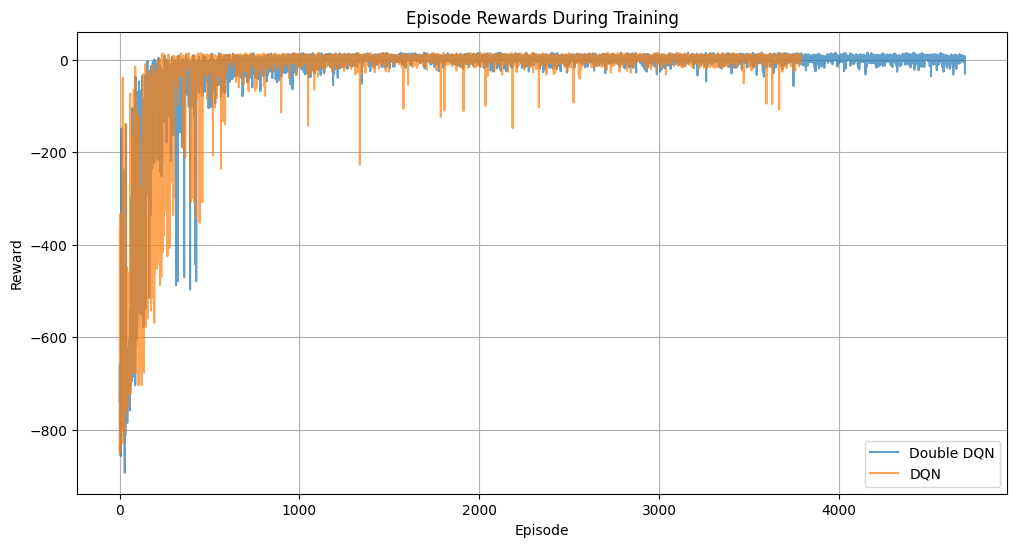

In [26]:
# Cell 18: Plot Comparison of DQN vs Double DQN
plt.figure(figsize=(12, 6))
plt.plot(history_ddqn.history['episode_reward'], label='Double DQN', alpha=0.7)
plt.plot(history_dqn.history['episode_reward'], label='DQN', alpha=0.7)
plt.title('Episode Rewards During Training')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()


## Comparison plot of all models

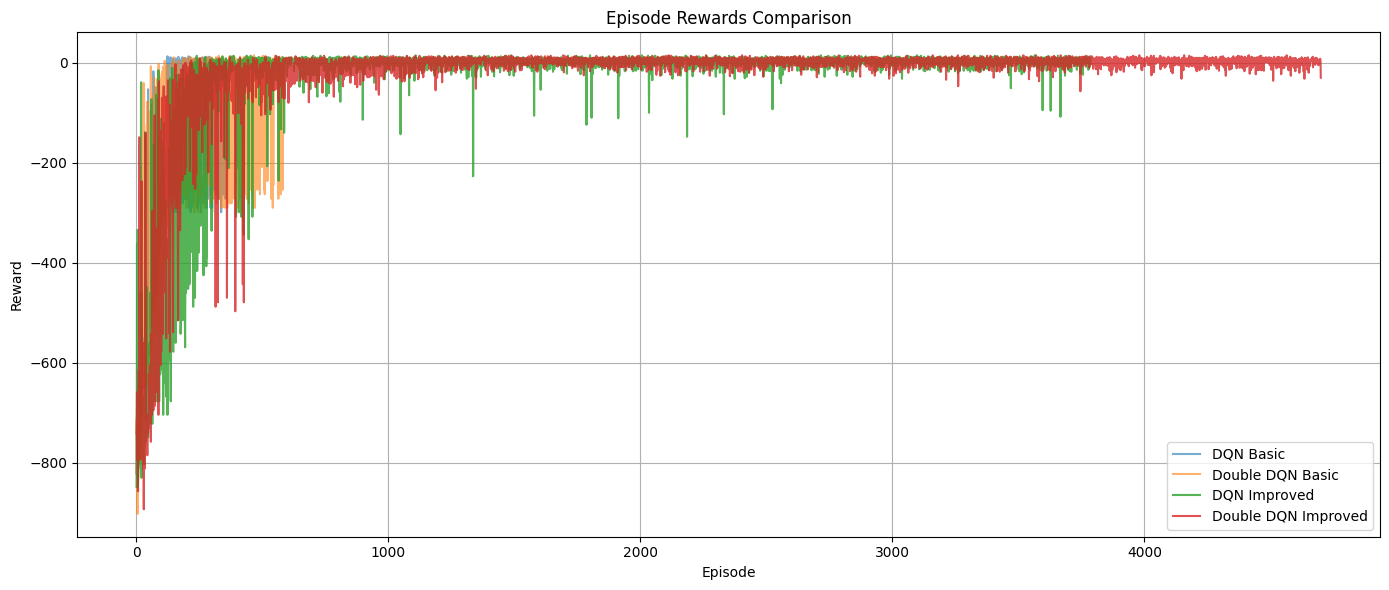

In [27]:
# Comparison plot of all models
plt.figure(figsize=(14, 6))
plt.plot(history_dqn_basic.history['episode_reward'], label='DQN Basic', alpha=0.6)
plt.plot(history_ddqn_basic.history['episode_reward'], label='Double DQN Basic', alpha=0.6)
plt.plot(history_dqn.history['episode_reward'], label='DQN Improved', alpha=0.8)
plt.plot(history_ddqn.history['episode_reward'], label='Double DQN Improved', alpha=0.8)
plt.title("Episode Rewards Comparison")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
